# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify all symbols

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

In [ ]:
# Install required packages (once per virtual environment)
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow[and-cuda] xgboost emnist
%reset -f

In [9]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import emnist
from IPython.display import display, Markdown
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# import packages for all models for use in Part 2: full model showdown.
# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings

In [10]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)

In [11]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
valid = pd.DataFrame()
valid['image'] = list(image)
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
valid['label'] = label
valid['class'] = class_label

In [ ]:
# Using the helper functions

# Plot a random image from the training set
index = np.random.randint(0, len(train))
show_image(train.iloc[index])

# Show a random set of 25 images in a 5x5 grid
show_grid(train.sample(25), title='Random 25 images')

# Show the first 25 images in a 5x5 grid
show_grid(train[:25], title='First 25 images')

# Isn't it nice to have a helper function to do this for you?

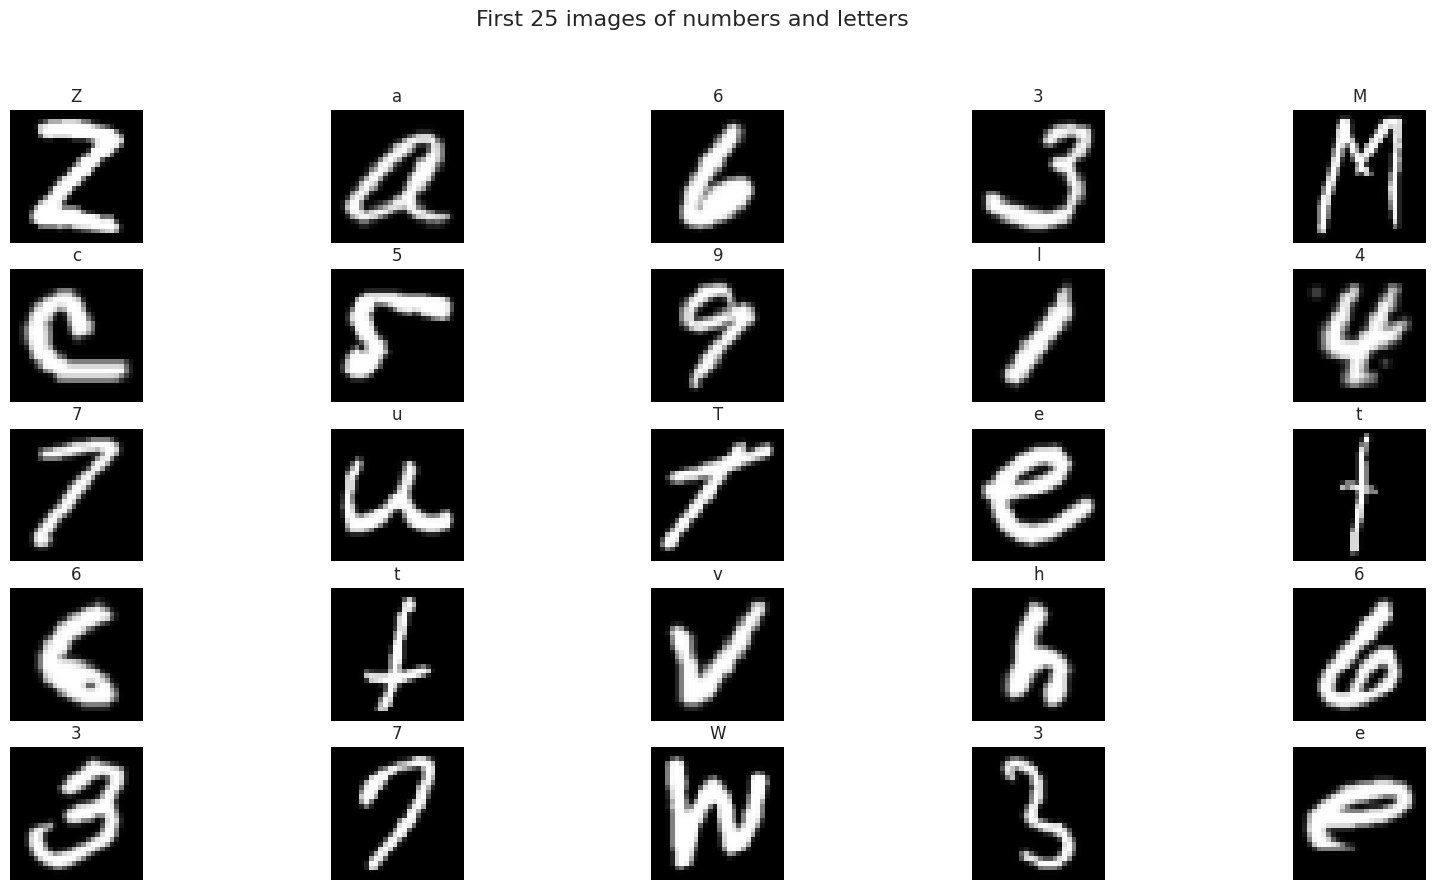

In [12]:
# Alphanumeric Classifier: Subset the data

# Subset `train` and `valid` to only include 0s and 1s
symbols_list = [str(i) for i in range(10)] + [chr(ord('A') + i) for i in range(26)] + [chr(ord('a') + i) for i in range(26)]

mask_train = train['class'].apply(lambda x: x in symbols_list)
train_01 = train[mask_train]
train_01.reset_index(drop=True, inplace=True)

mask_valid = valid['class'].apply(lambda x: x in symbols_list)
valid_01 = valid[mask_valid]
valid_01.reset_index(drop=True, inplace=True)



# Create a dictionary for performance metrics
metrics_dict = {}

show_grid(train_01[:25], title="First 25 images of numbers and letters")

In [13]:
# (OPTIONAL) We can define all the metrics we want to track in a dictionary
metrics_dict = {
    '0_vs_1' : { # task name (0 vs 1 classifier)
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [14]:
# Convert data to tensor
train_images = np.array(train_01['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train_01['label'])
valid_images = np.array(valid_01['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid_01['label'])


print("Training Images Shape:", train_images.shape)
print("Training Labels Shape:", train_labels.shape)
print("Validation Images Shape:", valid_images.shape)
print("Validation Labels Shape:", valid_labels.shape)

Training Images Shape: (697932, 28, 28, 1)
Training Labels Shape: (697932,)
Validation Images Shape: (116323, 28, 28, 1)
Validation Labels Shape: (116323,)


In [ ]:
# 0 vs 1 Classifier: Neural Network
task = 'AlphaNumeric'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

# Convert data to tensor
train_images = np.array(train_01['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train_01['label'])
valid_images = np.array(valid_01['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid_01['label'])

# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(62, activation='softmax')
])

# Compile the model, specifying the optimizer, loss function, and metrics 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model, saving the history of the training process
history = model.fit(train_images, train_labels, epochs=20, validation_data=(valid_images, valid_labels))

# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels)
predictions = model.predict(valid_images)
y_pred = np.argmax(predictions, axis=1)
 
# Calculate performance metrics
prec = precision_score(valid_labels, y_pred, average='macro')
rec = recall_score(valid_labels, y_pred, average='macro')
f1 = f1_score(valid_labels, y_pred, average='macro')
cm = confusion_matrix(valid_labels, y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}



In [ ]:
# Display performance metrics
display_metrics(task, model_name, metrics_dict)



In [ ]:
# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)

In [ ]:
# Show the performance metrics for all models as a raw dictionary

if not REBUILD:
    metrics_dict['AlphaNumeric']['neural_network'] = {
                                          'accuracy': 0.9995870590209961,
                                         'precision': 0.9992107340173638,
                                            'recall': 1.0,
                                                'f1': 0.9996052112120015,
                                  'confusion_matrix': [[5773,    5],
                                                       [   0, 6330]]
                                          }

display(metrics_dict)

In [ ]:
# create an empty DataFrame to hold the results
results_df = pd.DataFrame()

# iterate over the keys in the metrics_dict
for key in metrics_dict:
    
    # create a new DataFrame to hold the results for this key
    df = pd.DataFrame.from_dict(metrics_dict[key], orient='index')
    
    # add a new row to the DataFrame indicating the model name and metric type
    df = df.assign(model=key, metric=df.index)
    
    # set the index to the 'model' and 'metric' columns
    df = df.set_index(['model', 'metric'])
    
    # append the results to the main DataFrame
    results_df = pd.concat([results_df, df])

# display the resulting table
display(results_df)

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# set the x-axis labels
labels = ['accuracy', 'precision', 'recall', 'f1']

# iterate over the models in the metrics_dict
for i, model in enumerate(metrics_dict['AlphaNumeric'].keys()):
    # extract the metric values for this model
    values = [metrics_dict['AlphaNumeric'][model][label] for label in labels]
    
    # plot the values as a line
    ax.plot(labels, values, label=model, marker='o', color=colors[i])

    
# add a legend and title
ax.legend()
ax.set_title('Performance Metrics by Model')

# show the plot
plt.show()

In [ ]:
models = ['neural_network']
accuracies = [metrics_dict['AlphaNumeric'][model]['f1'] for model in models]

plt.bar(models, accuracies, color=colors)
plt.title('F1 Scores for Each Model', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([0.8, 1.0])
plt.show()


In [ ]:
# Create a mapping for digits
digits = {i: str(i) for i in range(10)}

# Create a mapping for uppercase and lowercase letters
letters = {i+10: letter for i, letter in enumerate(string.ascii_lowercase)}
letters.update({i+36: letter for i, letter in enumerate(string.ascii_uppercase)})

# Combine the mappings
index_to_char = {**digits, **letters}

plt.figure(figsize=(30, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=symbols_list, yticklabels=symbols_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 2. Classify digits vs. letters model showdown
Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

In [15]:
# Show the performance metrics for all models as a raw dictionary

if not REBUILD:
    metrics_dict['AlphaNumeric']['xgboost'] = {
                                          'accuracy': 0.9994218698381235,
                                         'precision': 0.999210484762356,
                                            'recall': 0.9996840442338073,
                                                'f1': 0.9994472084024323,
                                  'confusion_matrix': [[5773,    5],
                                                       [   2, 6328]]
                                          }
    metrics_dict['AlphaNumeric']['random_forest'] = {
                                          'accuracy': 0.9992566897918731,
                                         'precision': 0.9987375729840618,
                                            'recall': 0.9998420221169037,
                                                'f1': 0.9992894923817794,
                                  'confusion_matrix': [[5770,    8],
                                                      [   1, 6329]]
                                                 }
    metrics_dict['AlphaNumeric']['logistic_regression'] = {
                                          'accuracy': 0.9972745292368682,
                                         'precision': 0.9965305156915313,
                                            'recall': 0.9982622432859399,
                                                'f1': 0.9973956278115382,
                                  'confusion_matrix': [[5756,   22],
                                                       [  11, 6319]]
                                                 }
    metrics_dict['AlphaNumeric']['neural_network'] = {
                                          'accuracy': 0.9995870590209961,
                                         'precision': 0.9992107340173638,
                                            'recall': 1.0,
                                                'f1': 0.9996052112120015,
                                  'confusion_matrix': [[5773,    5],
                                                       [   0, 6330]]
                                          }

display(metrics_dict)

{'0_vs_1': {'logistic_regression': {'confusion_matrix': [],
   'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []},
  'xgboost': {'confusion_matrix': [],
   'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []},
  'random_forest': {'confusion_matrix': [],
   'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []},
  'neural_network': {'confusion_matrix': [],
   'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []}}}

In [ ]:
# 0 vs 1 Classifier: RandomForest
task = 'AlphaNumeric'
model_name = 'random_forest'
metrics_dict[task] = {model_name: {}}

# Initialize random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
rf_clf.fit(train_01['image_flat'].tolist(), train_01['label'])
y_pred = rf_clf.predict(valid_01['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred)
rec = recall_score(valid_01['label'], y_pred)
f1 = f1_score(valid_01['label'], y_pred)
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

In [ ]:
# 0 vs 1 Classifier: Logistic Regression 
task = 'AlphaNumeric'
model_name = 'logistic_regression'

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Scale the data
# When running without scaling the data, the model does not converge
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_01['image_flat'].tolist())
valid_scaled = scaler.transform(valid_01['image_flat'].tolist())

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Train and evaluate model
lr_clf.fit(train_scaled, train_01['label'])
y_pred = lr_clf.predict(valid_scaled)

# Calculate performance metrics
acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred)
rec = recall_score(valid_01['label'], y_pred)
f1 = f1_score(valid_01['label'], y_pred)
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

In [16]:
# 0 vs 1 Classifier: XGBoost
task = 'AlphaNumeric'
model_name = 'xgboost'

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=10, random_state=42, eval_metric='mlogloss', objective='multi:softmax')

# Train and evaluate model
xgb_clf.fit(train_01['image_flat'].tolist(), train_01['label'])
y_pred = xgb_clf.predict(valid_01['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred)
rec = recall_score(valid_01['label'], y_pred)
f1 = f1_score(valid_01['label'], y_pred)
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].